Triangle Packing - Minimal Bounding Triangle
Initial State:
  Loss: 40.2532
  Bounding Size: 3.9960
  Overlap: 0.107564
Iter    0: Loss= 40.2532, BoundingSize=3.9960, Overlap=0.107564
Iter  200: Loss=  5.3225, BoundingSize=3.2617, Overlap=0.000010
Iter  400: Loss=  3.5664, BoundingSize=2.6701, Overlap=0.000005
Iter  600: Loss=  2.5529, BoundingSize=2.2584, Overlap=0.000009
Iter  800: Loss=  2.0492, BoundingSize=2.0233, Overlap=0.000007
Iter  999: Loss=  1.9989, BoundingSize=1.9962, Overlap=0.000022
Optimization Complete!
Final bounding triangle leg length: 1.9962
Final bounding triangle area: 1.9924
Total small triangles area: 1.5000
Packing efficiency: 75.29%

All triangle vertices:
[[0.         0.99617221]
 [1.         0.99617221]
 [0.         1.99617221]
 [0.99617221 0.        ]
 [1.99617221 0.        ]
 [0.99617221 1.        ]
 [0.         0.        ]
 [1.         0.        ]
 [0.         1.        ]]
Max X: 1.9961722129783699, Max Y: 1.99617221297837
Bounding size: 1.9961722129783

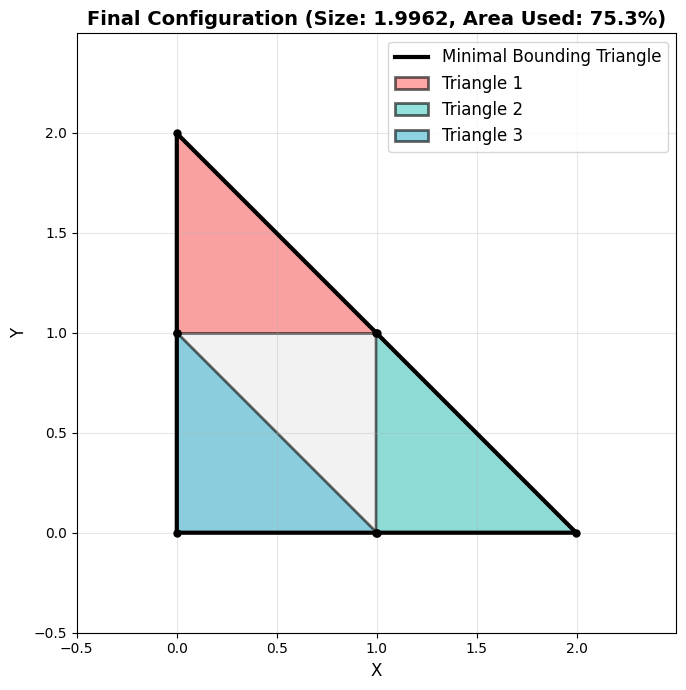

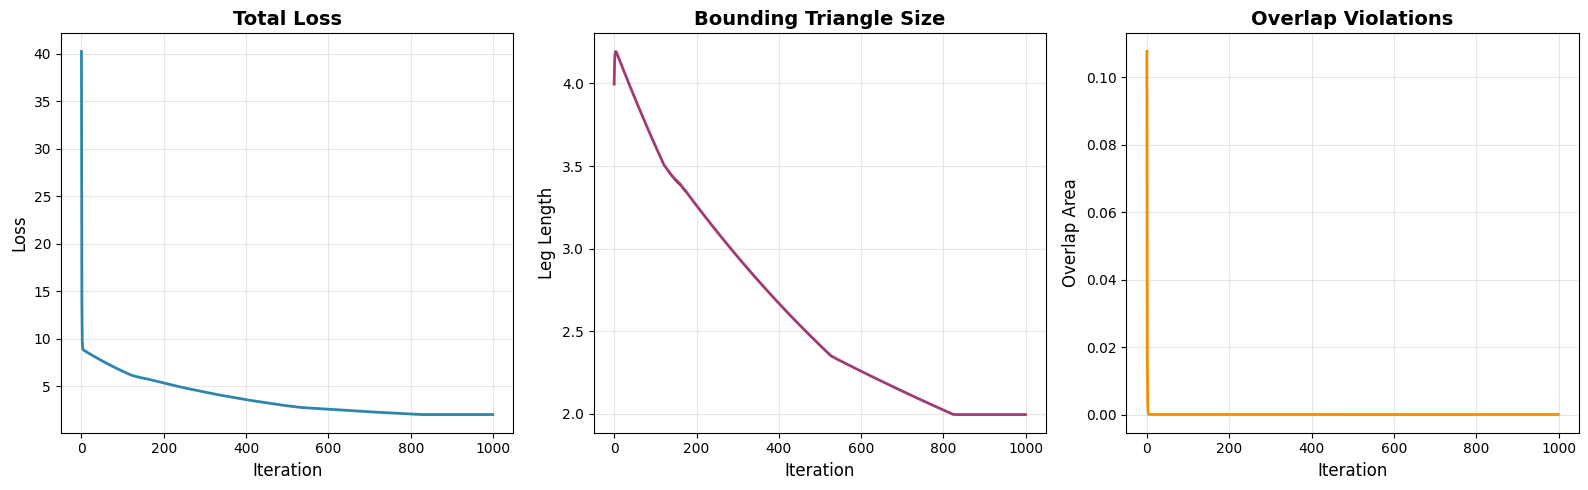

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Configuration
NUM_SMALL_TRIANGLES = 3
SMALL_TRIANGLE_LEG = 1.0
OVERLAP_PENALTY = 300.0
LEARNING_RATE = 0.001
NUM_ITERATIONS = 1000
EPSILON = 0.001  # For finite differences

def create_small_triangle(x, y, leg=SMALL_TRIANGLE_LEG):
    return [[x, y], [x + leg, y], [x, y + leg]]

def compute_minimal_bounding_triangle(positions):
    # Get all vertices from all small triangles
    all_vertices = []
    for x, y in positions:
        tri_verts = create_small_triangle(x, y)
        all_vertices.extend(tri_verts)
    
    # Convert to numpy array
    all_vertices = np.array(all_vertices)
    
    # For each vertex to be inside the triangle with hypotenuse y = size - x,
    # we need: x + y <= size for all vertices
    # Therefore: size >= max(x + y) over all vertices
    sum_coords = all_vertices[:, 0] + all_vertices[:, 1]
    bounding_size = np.max(sum_coords)
    
    return bounding_size

def create_bounding_triangle(size):
    return [[0, 0], [size, 0], [0, size]]

def compute_loss(params):
    # Extract parameters (only positions now!)
    positions = params.reshape(3, 2)
    
    # Compute minimal bounding triangle
    bounding_size = compute_minimal_bounding_triangle(positions)
    
    # Create Shapely polygons
    small_polys = [Polygon(create_small_triangle(x, y)) for x, y in positions]
    
    # Calculate overlap between small triangles
    total_overlap = 0.0
    for i in range(NUM_SMALL_TRIANGLES):
        for j in range(i + 1, NUM_SMALL_TRIANGLES):
            if small_polys[i].intersects(small_polys[j]):
                total_overlap += small_polys[i].intersection(small_polys[j]).area
    
    # Total loss: minimize bounding size (or area), heavily penalize overlaps
    # Area of right isosceles triangle = 0.5 * leg^2
    bounding_area = 0.5 * bounding_size ** 2
    
    loss = bounding_area + OVERLAP_PENALTY * total_overlap
    
    return loss, bounding_size, total_overlap

def compute_gradients(params, epsilon=EPSILON):
    gradients = np.zeros_like(params)
    base_loss, _, _ = compute_loss(params)
    
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += epsilon
        loss_plus, _, _ = compute_loss(params_plus)
        gradients[i] = (loss_plus - base_loss) / epsilon
    
    return gradients

def optimize():
    # Initialize parameters - only positions now!
    np.random.seed(42)
    positions = np.random.uniform(0.5, 2.0, size=(NUM_SMALL_TRIANGLES, 2))
    params = positions.flatten()
    
    # Track history
    loss_history = []
    size_history = []
    overlap_history = []
    
    print("=" * 60)
    print("Triangle Packing - Minimal Bounding Triangle")
    print("=" * 60)
    loss, bounding_size, overlap = compute_loss(params)
    print(f"Initial State:")
    print(f"  Loss: {loss:.4f}")
    print(f"  Bounding Size: {bounding_size:.4f}")
    print(f"  Overlap: {overlap:.6f}")
    print("=" * 60)
    
    # Optimization loop
    for iteration in range(NUM_ITERATIONS):
        # Compute current loss
        loss, bounding_size, overlap = compute_loss(params)
        
        # Track history
        loss_history.append(loss)
        size_history.append(bounding_size)
        overlap_history.append(overlap)
        
        # Compute gradients
        gradients = compute_gradients(params)
        
        # Update parameters
        params = params - LEARNING_RATE * gradients
        
        # Constrain small triangles to first quadrant (x, y >= 0)
        params = np.maximum(params, 0.0)
        
        # Print progress
        if iteration % 200 == 0 or iteration == NUM_ITERATIONS - 1:
            print(f"Iter {iteration:4d}: Loss={loss:8.4f}, BoundingSize={bounding_size:6.4f}, "
                  f"Overlap={overlap:.6f}")
    
    print("=" * 60)
    print("Optimization Complete!")
    print(f"Final bounding triangle leg length: {bounding_size:.4f}")
    print(f"Final bounding triangle area: {0.5 * bounding_size**2:.4f}")
    print(f"Total small triangles area: {3 * 0.5 * SMALL_TRIANGLE_LEG**2:.4f}")
    print(f"Packing efficiency: {(3 * 0.5 * SMALL_TRIANGLE_LEG**2) / (0.5 * bounding_size**2) * 100:.2f}%")
    print("=" * 60)
    
    return params, loss_history, size_history, overlap_history

def visualize_result(params):
    positions = params.reshape(3, 2)
    bounding_size = compute_minimal_bounding_triangle(positions)
    
    # Debug: Check if triangles are actually contained
    all_verts = []
    for x, y in positions:
        all_verts.extend(create_small_triangle(x, y))
    all_verts = np.array(all_verts)
    print(f"\nAll triangle vertices:")
    print(all_verts)
    print(f"Max X: {np.max(all_verts[:, 0])}, Max Y: {np.max(all_verts[:, 1])}")
    print(f"Bounding size: {bounding_size}")
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Plot bounding triangle
    bounding_verts = create_bounding_triangle(bounding_size)
    bounding_x = [v[0] for v in bounding_verts] + [bounding_verts[0][0]]
    bounding_y = [v[1] for v in bounding_verts] + [bounding_verts[0][1]]
    ax.plot(bounding_x, bounding_y, 'k-', linewidth=3, label='Minimal Bounding Triangle')
    ax.fill(bounding_x, bounding_y, alpha=0.1, color='gray')
    
    # Plot small triangles
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for idx, (x, y) in enumerate(positions):
        verts = create_small_triangle(x, y)
        xs = [v[0] for v in verts] + [verts[0][0]]
        ys = [v[1] for v in verts] + [verts[0][1]]
        ax.fill(xs, ys, alpha=0.6, color=colors[idx], edgecolor='black', 
                linewidth=2, label=f'Triangle {idx+1}')
        
        # Plot vertices as dots for debugging
        for v in verts:
            ax.plot(v[0], v[1], 'ko', markersize=5)
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    # Calculate percentage of area used up
    area = (3 * 0.5 * SMALL_TRIANGLE_LEG**2) / (0.5 * bounding_size**2) * 100
    
    ax.set_title(f'Final Configuration (Size: {bounding_size:.4f}, Area Used: {area:.1f}%)', 
                 fontsize=14, fontweight='bold')
    
    # Set axis limits with some padding
    ax.set_xlim(-0.5, bounding_size + 0.5)
    ax.set_ylim(-0.5, bounding_size + 0.5)
    
    plt.tight_layout()
    plt.show()

def plot_history(loss_history, size_history, overlap_history):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Loss
    axes[0].plot(loss_history, linewidth=2, color='#2E86AB')
    axes[0].set_xlabel('Iteration', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Total Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Bounding triangle size
    axes[1].plot(size_history, linewidth=2, color='#A23B72')
    axes[1].set_xlabel('Iteration', fontsize=12)
    axes[1].set_ylabel('Leg Length', fontsize=12)
    axes[1].set_title('Bounding Triangle Size', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Overlap violations
    axes[2].plot(overlap_history, linewidth=2, color='#F18F01')
    axes[2].set_xlabel('Iteration', fontsize=12)
    axes[2].set_ylabel('Overlap Area', fontsize=12)
    axes[2].set_title('Overlap Violations', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run optimization
    final_params, loss_hist, size_hist, overlap_hist = optimize()
    
    # Visualize results
    visualize_result(final_params)
    plot_history(loss_hist, size_hist, overlap_hist)